# Stroke prediction

In [15]:
# import of neccesary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Type_Of_Work,Residence,Avg_Glucose,BMI,Smoking_Status,Stroke
0,31153,Male,1104.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30650,Male,21204.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,17412,Female,2928.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,57008,Female,25578.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46657,Male,5128.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


missing values in % : 

 Smoking_Status    30.63
BMI                3.37
Stroke             0.00
Avg_Glucose        0.00
Residence          0.00
Type_Of_Work       0.00
Ever_Married       0.00
Heart_Disease      0.00
Hypertension       0.00
Age_In_Days        0.00
Gender             0.00
ID                 0.00
dtype: float64


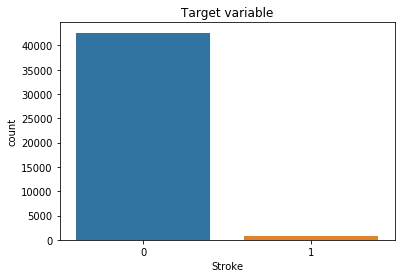

In [2]:
# first look at the data
df = pd.read_csv(r'Stroke_Prediction.csv')
display(df.head())
# display(df.dtypes)
# number of missing values
# display(df.describe())

def missing(df):
    print ('missing values in % : \n\n', round((df.isnull().sum() * 100/ len(df)),2).sort_values(ascending=False))

missing(df)
# plot storke - no stroke proportion
plt.title('Target variable')
ax = sns.countplot(x="Stroke", data=df)

##  filling missing data and removing outliers

In [3]:
# fill missing values for BMI with median value       
df['BMI'].fillna(np.median, inplace =True)
df['BMI'] = pd.to_numeric(df['BMI'], errors='coerce')

# classify BMI into obese (0) and not obese (1)
series = df['BMI'] 
df['obese'] = [0 if x <=35 else 1 for x in series]

# remove outliers - age more tha 100 years old
df = df.loc[df['Age_In_Days'] < 40000]
df = df.loc[df['Age_In_Days'] > 0]

df['Age_years'] = df['Age_In_Days']/365

df['Smoking_Status'].fillna('never smoked', inplace =True)
# remove ramaining null values
df = df.dropna()
missing(df)

missing values in % : 

 Age_years         0.0
obese             0.0
Stroke            0.0
Smoking_Status    0.0
BMI               0.0
Avg_Glucose       0.0
Residence         0.0
Type_Of_Work      0.0
Ever_Married      0.0
Heart_Disease     0.0
Hypertension      0.0
Age_In_Days       0.0
Gender            0.0
ID                0.0
dtype: float64


## Explanatory analysis of variables

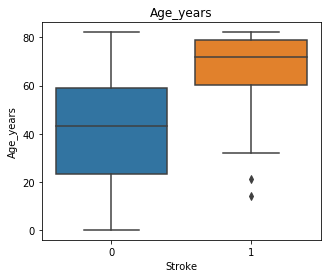

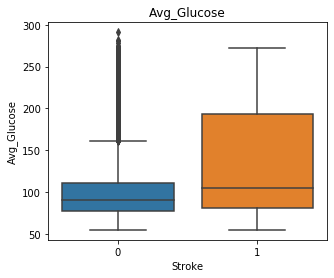

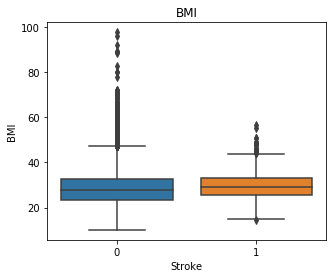

In [4]:
lista_numeric = ['Age_years', 'Avg_Glucose', 'BMI']

for i in lista_numeric:
    plt.figure(figsize=(5, 4))
    plt.title(i)
    ax = sns.boxplot(x="Stroke", y=i, data=df)

<Figure size 720x288 with 0 Axes>

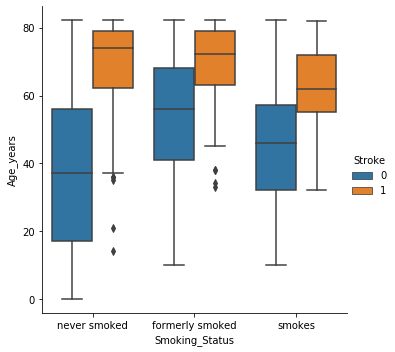

<Figure size 720x288 with 0 Axes>

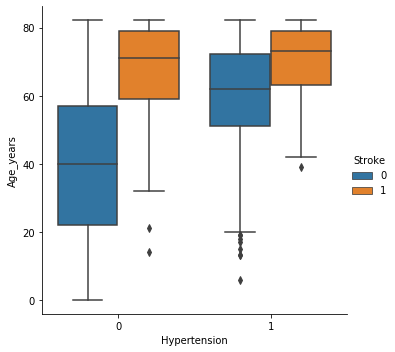

<Figure size 720x288 with 0 Axes>

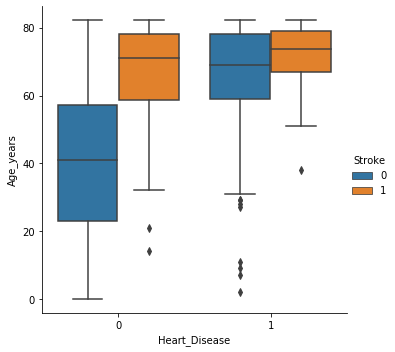

<Figure size 720x288 with 0 Axes>

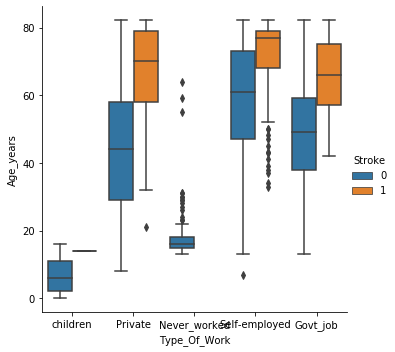

<Figure size 720x288 with 0 Axes>

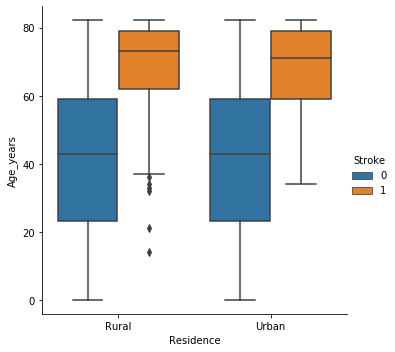

In [5]:
lista_cat = ["Smoking_Status","Hypertension","Heart_Disease","Type_Of_Work","Residence"]

for i in lista_cat: 
    plt.figure(figsize=(10, 4))
    sns.catplot(x=i, y="Age_years", hue="Stroke", kind="box", data=df)

### Recode categorical variables

In [6]:
# 0: male, 1:female
series = df['Gender']
df['Gender'] = [0 if x == 'Male' else 1 for x in series]
series = df['Ever_Married']

df['Ever_Married'] = [0 if x == 'No' else 1 for x in series]
series = df['Residence']

# 0: rural, 1: urban
df['Residence'] = [0 if x == 'Rural' else 1 for x in series]

### make dummy variables

In [7]:
# set no smoking status for children
df.loc[df['Type_Of_Work'] =='children', 'Smoking_Status'] = 'never smoked'

df = pd.get_dummies(data = df, columns= ['Type_Of_Work'])
df = pd.get_dummies(data = df, columns= ['Smoking_Status'])
display(df.head())

,ID,Gender,Age_In_Days,Hypertension,Heart_Disease,Ever_Married,Residence,Avg_Glucose,BMI,Stroke,obese,Age_years,Type_Of_Work_Govt_job,Type_Of_Work_Never_worked,Type_Of_Work_Private,Type_Of_Work_Self-employed,Type_Of_Work_children,Smoking_Status_formerly smoked,Smoking_Status_never smoked,Smoking_Status_smokes
0,31153,0,1104.0,0,0,0,0,95.12,18.0,0,0,3.024658,0,0,0,0,1,0,1,0
1,30650,0,21204.0,1,0,1,1,87.96,39.2,0,1,58.093151,0,0,1,0,0,0,1,0
2,17412,1,2928.0,0,0,0,1,110.89,17.6,0,0,8.021918,0,0,1,0,0,0,1,0
3,57008,1,25578.0,0,0,1,0,69.04,35.9,0,1,70.076712,0,0,1,0,0,1,0,0
4,46657,0,5128.0,0,0,0,0,161.28,19.1,0,0,14.049315,0,1,0,0,0,0,1,0


# Predictions

In [8]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 

Using TensorFlow backend.


In [9]:
# Function for classification with diffrent ML methods

def modeling(X_train_res, X_test, y_train_res, y_test, df, model, name, variables):
    
    # Setup the pipeline steps: scaling and fitting model 
    steps = [('scaler', StandardScaler()),
                         ('reg', model)]
    
    # Create the pipeline: pipeline
    pipeline = Pipeline(steps)

    # Fit it to the training data
    pipeline.fit(X_train_res, y_train_res)

    # Predict the labels of the test set: y_pred
    y_pred = pipeline.predict(X_test)

    # Compute and print AUC score
    auc_roc = roc_auc_score(y_test, y_pred)
    print("AUC: {}, model : {}".format(auc_roc, name))

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)

    labels = ['No Stroke', 'Stroke']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.title('CM  ' +  name)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve ' +  name)
    plt.show()

## selection of explanatory variables

In [20]:
all_variables = [i for i in list(df.columns) if i not in ['Stroke', 'ID', 'Age_In_Days']]
variables_short = ['Age_In_Days', 'Heart_Disease', 'Avg_Glucose', 'BMI']

## spliting into train-test and upsampling of minority class

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[variables_short], df['Stroke'], test_size=0.3)
    
## Up-sample Minority Class of stroke using SMOTE algorithm
X_train_res, y_train_res = sm.fit_sample(X_train, y_train) 

AUC: 0.7686804777363532, model : logistic regression
Confusion matrix:
 [[9031 3356]
 [  37  156]]


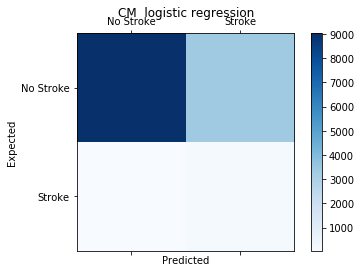

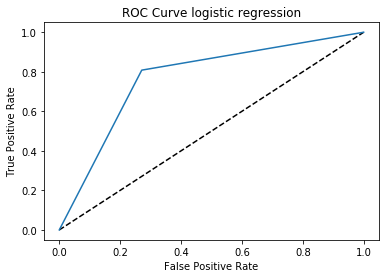

In [24]:
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]} # l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg, grid, scoring='roc_auc',cv=10)

modeling(X_train_res, X_test, y_train_res, y_test, df, logreg_cv, 'logistic regression', variables_short)

In [ ]:
from sklearn.svm import SVC
from sklearn import svm

In [ ]:

svm = svm.SVC(kernel='linear', 
           class_weight='balanced', # penalize
            probability=True)
rf = RandomForestClassifier()
xgb = XGBClassifier()
dec_tree = DecisionTreeClassifier(random_state=0)

modeling(df, svm, 'SVM', variables_short)
modeling(df, rf, 'Random Forest', variables_short)
modeling(df, xgb, 'Xgboost', variables_short)
modeling(df, dec_tree, 'Decision Trees', variables_short)

In [ ]:
# vaiable importance

coef_df = DataFrame(zip(X_train.columns, np.transpose(model.coef_)))
coef_df.reset_index()
coef_df.columns= ['feature', 'coef']
coef_df['coef'] = coef_df['coef'].astype(float)
df_coef_sort = coef_df.sort_values(by=['coef'])
    
plt.figure(figsize=(10,8))
_ = sns.barplot(y = 'feature', x = 'coef', data = df_coef_sort)
_.set(xlabel='Beta coefs', ylabel='Features')
plt.xticks(rotation=45)
plt.show()

In [ ]:
################################################################################################################################

In [ ]:
explainer = shap.KernelExplainer(pipeline.predict, X_train, link="identity")
shap_values = explainer.shap_values(X_train)

# visualise the statistic modelling outputs with SHAP
shap.summary_plot(shap_values, X_train)

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values, X_train) 

## SHAP - does not work